# Import Library

In [57]:
# Data Prep
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np
import keras, os
 
# Visualization lib 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# import seaborn as sn
import pandas as pd
# import json
# import glob
# import os

# Oversampling
# import os
import random
import string
import shutil

# Splitting data
# import os
# import shutil
from sklearn.model_selection import train_test_split

# # Report Metrics 
# from sklearn import metrics

# # Model Development
from keras.models import Sequential
# from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, LeakyReLU, GlobalMaxPooling2D, Activation
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.optimizers import Adam
# import datetime
# from time import time

# Data Preparation

In [58]:
path_data = "../Oprek/byPhiard_01/"
images, labels = [], []

for dirname, _, filenames in os.walk(path_data):
    for filename in filenames:
        label = os.path.basename(os.path.dirname(os.path.join(dirname, filename)))
        images.append(os.path.join(dirname, filename).split('/')[-1])  
        labels.append(label)

In [59]:
label2cat = np.unique(labels)
label2cat

array(['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na',
       'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya'],
      dtype='<U3')

In [60]:
ints = np.arange(0, len(label2cat))
dicts = dict(zip(label2cat, ints))
dicts

{'ba': 0,
 'ca': 1,
 'da': 2,
 'dha': 3,
 'ga': 4,
 'ha': 5,
 'ja': 6,
 'ka': 7,
 'la': 8,
 'ma': 9,
 'na': 10,
 'nga': 11,
 'nya': 12,
 'pa': 13,
 'ra': 14,
 'sa': 15,
 'ta': 16,
 'tha': 17,
 'wa': 18,
 'ya': 19}

In [61]:
datas = pd.DataFrame({'image_id':images, 'label':labels})
datas.head(), datas.shape

(                          image_id label
 0             ba\ba116.pred3.b.png    ba
 1  ba\ba116.pred3.b_aug_0_1024.png    ba
 2  ba\ba116.pred3.b_aug_0_1040.png    ba
 3  ba\ba116.pred3.b_aug_0_1061.png    ba
 4   ba\ba116.pred3.b_aug_0_108.png    ba,
 (13000, 2))

In [62]:
index = []
for i in range(len(datas)):
    try:
        Image.open(path_data + str(datas['label'].values[i]) + '/' + str(datas['image_id'].values[i]))
    except Image.UnidentifiedImageError:
        index.append(i)
    except FileNotFoundError:
        index.append(i)

datas = datas.drop(index)

In [63]:
# Menampilkan datas.head(), datas.shape hanya jika data masih kotor
if index:
    print(f"Data masih kotor. Jumlah baris yang dihapus: {len(index)}")
    print(datas.head(), datas.shape)
else:
    print("Data sudah bersih. Tidak ada gambar yang dihapus!")

Data masih kotor. Jumlah baris yang dihapus: 13000
Empty DataFrame
Columns: [image_id, label]
Index: [] (0, 2)


In [64]:
# Menghitung jumlah gambar per kelas
file_list = os.listdir(path_data)

jumlah_gambar_per_kelas = []

for kelas in file_list:
    kelas_path = os.path.join(path_data, kelas)
    jumlah_gambar = len(os.listdir(kelas_path))
    jumlah_gambar_per_kelas.append(jumlah_gambar)

# Mengecek apakah jumlah data per kelas sudah seimbang
balanced = all(jumlah == jumlah_gambar_per_kelas[0] for jumlah in jumlah_gambar_per_kelas)
 
# Menampilkan pesan sesuai dengan hasil pemeriksaan
if balanced:
    print("Balanced Data !")
else:
    print("Imbalanced Data !!!\n")
    # Jika imbalanced, tampilkan jumlah data per kelas
    for kelas, jumlah in zip(file_list, jumlah_gambar_per_kelas):
        print(f'Aksara {kelas} jumlah: {jumlah}')

Balanced Data !


## Oversampling

In [65]:
# List kelas
kelas_aksara = ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']

# Target jumlah gambar per kelas
target_jumlah = 650

In [66]:
# Loop untuk setiap kelas
for kelas in kelas_aksara:
    # Path kelas
    kelas_path = os.path.join(path_data, kelas)
    
    # Jumlah gambar saat ini
    jumlah_gambar = len(os.listdir(kelas_path))
    
    # Selisih gambar yang perlu ditambahkan
    selisih = target_jumlah - jumlah_gambar
    
    # Jika selisih positif, lakukan oversampling
    if selisih > 0:
        # Ambil sampel acak dari gambar yang sudah ada
        gambar_oversampling = random.sample(os.listdir(kelas_path), selisih)
        
        # Copy gambar oversampling ke dalam kelas
        for gambar in gambar_oversampling:
            source_path = os.path.join(kelas_path, gambar)
            
            # Generate sufiks acak
            sufiks_acak = ''.join(random.choices(string.ascii_letters + string.digits, k=8))
            
            # Tentukan path tujuan dengan menambahkan sufiks acak
            target_path = os.path.join(kelas_path, f'{os.path.splitext(gambar)[0]}_{sufiks_acak}{os.path.splitext(gambar)[1]}')
            
            # Salin gambar ke target path
            shutil.copy(source_path, target_path)

## Splitting data

In [67]:
# Path ke folder data asli
data_split = (path_data) 

# Path untuk folder baru yang akan dibuat
output_path = "../Oprek/Data_Split"

# Daftar kelas
classes = os.listdir(data_split)

In [68]:
# Membuat folder baru untuk data pelatihan dan pengujian
train_path = os.path.join(output_path, 'train')
test_path = os.path.join(output_path, 'test')

os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

In [69]:
# Memisahkan data dengan rasio 70:30 untuk setiap kelas
for class_name in classes:
    class_path = os.path.join(data_split, class_name)
    images = os.listdir(class_path)

    # Memisahkan data menjadi train dan test
    train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)

    # Membuat folder untuk setiap kelas di dalam folder train dan test
    train_class_path = os.path.join(train_path, class_name)
    test_class_path = os.path.join(test_path, class_name)

    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    # Menyalin file ke folder train
    for image in train_images:
        src_path = os.path.join(class_path, image)
        dst_path = os.path.join(train_class_path, image)
        shutil.copy(src_path, dst_path)

    # Menyalin file ke folder test
    for image in test_images:
        src_path = os.path.join(class_path, image)
        dst_path = os.path.join(test_class_path, image)
        shutil.copy(src_path, dst_path)

print("Data berhasil dibagi ke dalam folder train dan test dengan rasio 70:30 !")

Data berhasil dibagi ke dalam folder train dan test dengan rasio 70:30 !


## ImageDataGenerator

In [70]:
# Tentukan jalur direktori untuk data latih, validasi, dan uji
train_data = '../Oprek/data_split/train'
test_data = '../Oprek/data_split/test'

In [71]:
# Applying Data normalization and Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    train_data,
    # directory=train_data,
    batch_size=32,
    color_mode="rgb",
    target_size=(224, 224),
    class_mode="categorical"
)

validation_generator = validation_datagen.flow_from_directory(
    test_data,
    # directory=test_data,
    batch_size=32,
    color_mode="rgb",
    target_size=(224, 224),
    class_mode="categorical"
)

Found 9100 images belonging to 20 classes.
Found 3900 images belonging to 20 classes.


## Data Visualization

### Javanese Script Visualization

In [72]:
def show_images(image_files):  
    plt.figure() # specifying the overall grid size 
    fig = plt.figure(figsize=(10, 10))
    fig.patch.set_facecolor('xkcd:gray')

    for i in range(len(image_files)):
        plt.subplot(5, 5, i + 1)    # the number of images in the grid is 5*5 (25)
        img = mpimg.imread(image_files[i])
        plt.imshow(img)
        plt.tight_layout()
        plt.axis('off')
        
        # Ambil nama kelas dari path
        kelas_terpilih = os.path.basename(os.path.dirname(image_files[i]))
        plt.title(kelas_terpilih)

    plt.show()

In [73]:
def list_files(directory):
    arr = []
    for root, dirs, files in os.walk(directory):
        for name in files:
            if name.lower().endswith((".png")):
                arr.append(os.path.join(root, name))
                break
    return arr

<Figure size 640x480 with 0 Axes>

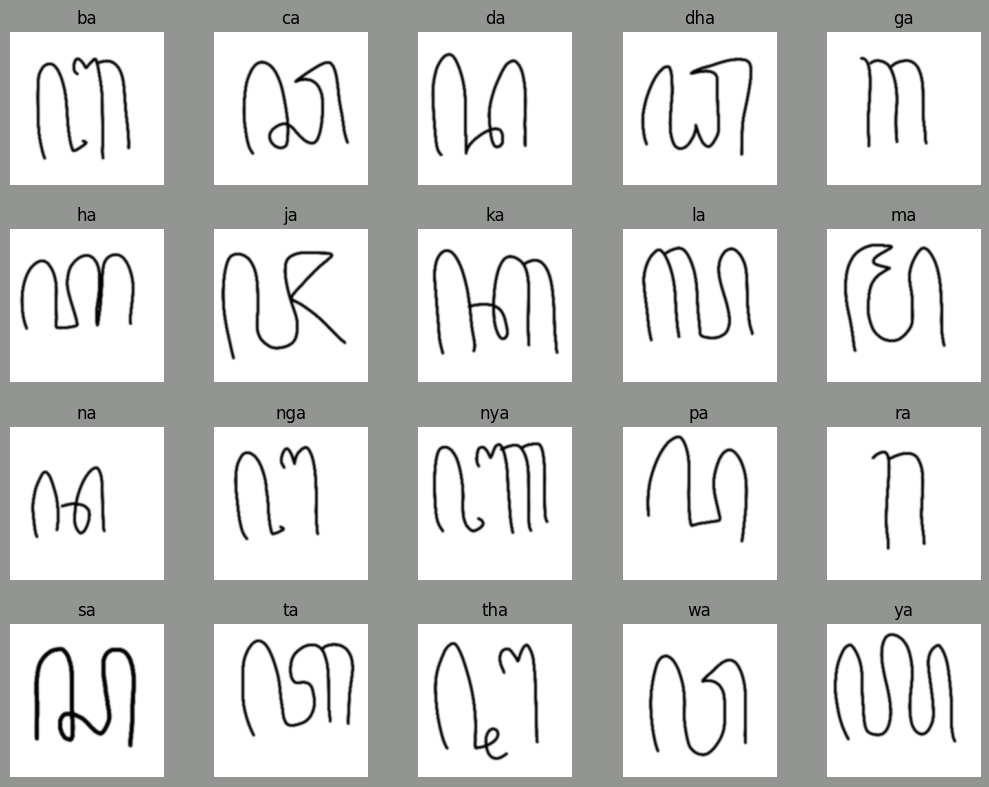

In [74]:
image_list = list_files(path_data)
show_images(image_list)

### Oversampling Visualization

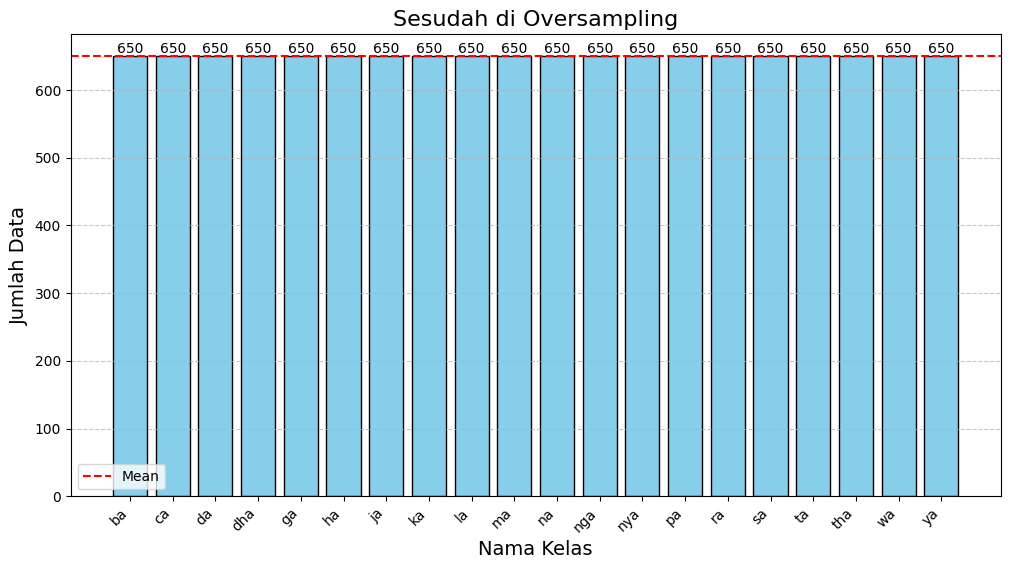

In [75]:
# Inisialisasi dictionary untuk menyimpan jumlah setiap kelas
counter_kelas = {}

# Menghitung jumlah setiap kelas
for kelas_folder in os.listdir(path_data):
    kelas_folder_path = os.path.join(path_data, kelas_folder)
    
    # Memastikan bahwa yang sedang diiterasi adalah direktori (bukan file)
    if os.path.isdir(kelas_folder_path):
        # Inisialisasi hitungan untuk kelas tertentu
        kelas_counter = 0
        
        # Menghitung jumlah file PNG di dalam subfolder
        for file in os.listdir(kelas_folder_path):
            if file.lower().endswith('.png'):
                kelas_counter += 1
        
        # Menyimpan jumlah file PNG untuk kelas tertentu
        counter_kelas[kelas_folder] = kelas_counter

# Memisahkan nama kelas dan jumlah
kelas = list(counter_kelas.keys())
jumlah = list(counter_kelas.values())

# Membuat diagram batang dengan label dan warna yang berbeda
fig, ax = plt.subplots(figsize=(12, 6))  # Mengatur ukuran figur
bars = ax.bar(kelas, jumlah, color='skyblue', edgecolor='black')  # Menyesuaikan warna batang

# Menambahkan label dan judul
plt.xlabel('Nama Kelas', fontsize=14)  # Menyesuaikan ukuran font dan label sumbu x
plt.ylabel('Jumlah Data', fontsize=14)  # Menyesuaikan ukuran font dan label sumbu y
plt.title('Sesudah di Oversampling', fontsize=16)  # Menyesuaikan ukuran font judul

# Menambahkan label pada setiap batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10, color='black')  # Menyesuaikan ukuran font dan warna teks
    
# Menyesuaikan tampilan sumbu x
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotasi label sumbu x, penempatan horizontal, dan ukuran font

# Menyesuaikan tampilan sumbu y
plt.yticks(fontsize=10)  # Menyesuaikan ukuran font sumbu y

# Menambahkan grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menambahkan garis horizontal pada mean atau median (opsional)
plt.axhline(y=np.mean(jumlah), color='red', linestyle='--', label='Mean')  # Atau ganti dengan np.median(jumlah) untuk median
plt.legend()

# Menampilkan diagram batang
plt.show()

### Data Splitting Visualization

In [76]:
def count_files(dir):
    arr = []
    for root, dirs, files in os.walk(dir):
        count = 0
        for name in files:
            if name.endswith(".png"):
                count += 1
        if count > 0:
            arr.append(count)
    return arr

In [77]:
def get_all_char_names(dir):
    arr = []
    for root, dirs, files in os.walk(dir):
        # print(dirs)
        arr.append(dirs)
        break
    return arr

20
[['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']]


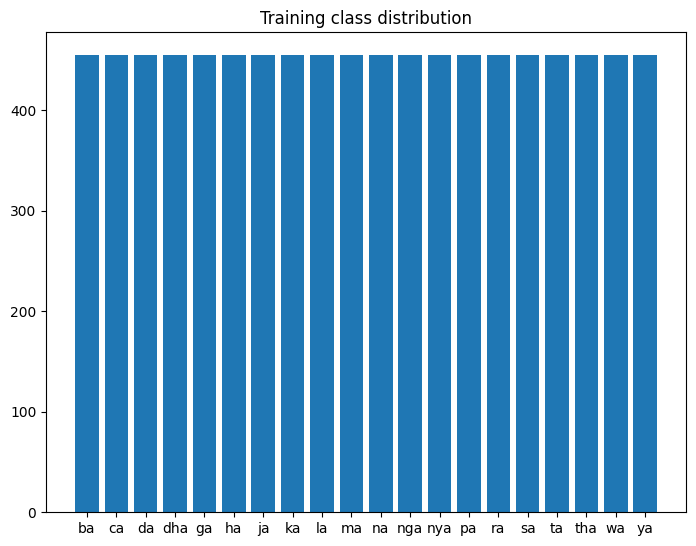

In [78]:
image_count = count_files("../Oprek/data_split/train/")
print(len(image_count))
chars = get_all_char_names("../Oprek/data_split/train/")
print(chars)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(chars[0], image_count)
plt.title("Training class distribution")
plt.show()

20
[['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']]


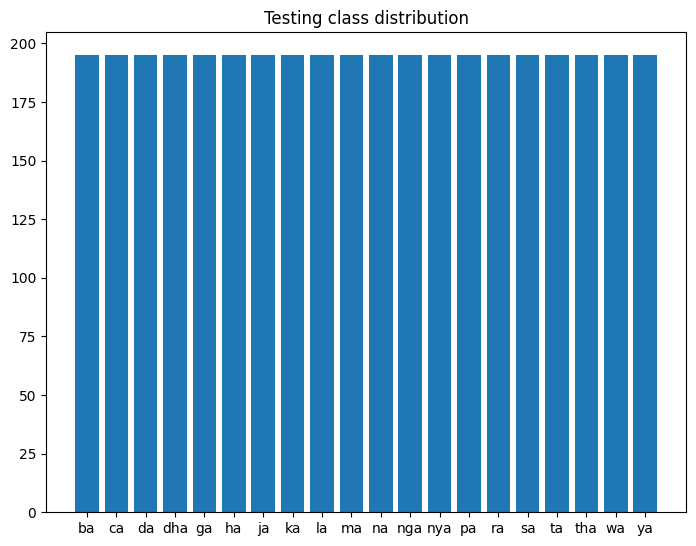

In [79]:
image_count = count_files("../Oprek/data_split/test")
print(len(image_count))
chars = get_all_char_names("../Oprek/data_split/test")
print(chars)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(chars[0], image_count)
plt.title("Testing class distribution")
plt.show()

# Build the Model

In [80]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import LearningRateScheduler
# from tensorflow.keras import backend as K

# # Fungsi untuk mengatur learning rate dengan eksponensial decay
# def lr_scheduler(epoch, lr):
#     decay_rate = 0.9
#     decay_step = 10
#     if epoch % decay_step == 0 and epoch:
#         return lr * decay_rate
#     return lr

# # Fungsi untuk mengatur weight decay
# def add_weight_decay(model, weight_decay):
#     if weight_decay is None:
#         return

#     for layer in model.layers:
#         if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
#             layer.add_loss(lambda: tf.keras.regularizers.l2(weight_decay)(layer.kernel))

In [81]:
# # Fungsi untuk mengatur gradient clipping
# def get_model():
#     model = Sequential()

#     # Tambahkan layer-layer CNN beserta Batch Normalization
#     model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2, 2)))

#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2, 2)))

#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D((2, 2)))

#     model.add(Flatten())

#     # Tambahkan Dense layer dengan Batch Normalization
#     model.add(Dense(128, activation='relu'))
#     model.add(BatchNormalization())

#     # Output layer
#     model.add(Dense(20, activation='softmax'))

#     return model

# # Inisialisasi model
# model = get_model()

# # Learning rate scheduling
# lr_schedule = LearningRateScheduler(lr_scheduler)

# # Weight Decay
# weight_decay = 1e-4
# add_weight_decay(model, weight_decay)

# # Gradient Clipping
# adam_optimizer = Adam(clipnorm=1.0)

# # Compile model dengan Adam optimizer
# model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# # Tampilkan summary dari model
# model.summary()

In [82]:
# # Latih model dengan data generator
# history = model.fit(train_data,
#                     epochs=5,
#                     validation_data=validation_data,
#                     callbacks=[lr_schedule])

In [83]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import LearningRateScheduler
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras import backend as K

# # Define VGG16 model with Batch Normalization
# def vgg16_model(input_shape=(150, 150, 3), num_classes=20):
#     model = Sequential()

#     # Block 1
#     model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
#     model.add(BatchNormalization())
#     model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#     # Block 2
#     model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#     # Block 3
#     model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#     # Flatten and fully connected layers
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dense(128, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dense(num_classes, activation='softmax'))

#     return model

In [84]:
# # Set random seed for reproducibility
# tf.random.set_seed(42)

# # Define learning rate schedule
# def lr_schedule(epoch):
#     lr = 1e-3
#     if epoch > 50:
#         lr *= 0.1
#     elif epoch > 75:
#         lr *= 0.01
#     return lr

# # Create VGG16 model with Batch Normalization
# model = vgg16_model()

In [85]:
# # Define Adam optimizer with weight decay and gradient clipping
# opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
# opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, clipvalue=0.5)

# # Compile the model
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# # Learning rate scheduling callback
# lr_scheduler = LearningRateScheduler(lr_schedule)

# # Print model summary
# model.summary()

## Train

In [86]:
# # Import library yang dibutuhkan
# from tensorflow.keras.callbacks import ModelCheckpoint

# # Model fitting
# epochs = 5
# batch_size = 16  # Sesuaikan dengan kebutuhan Anda
# steps_per_epoch = train_generator.samples // batch_size
# validation_steps = validation_generator.samples // batch_size

# # Callback untuk menyimpan model terbaik berdasarkan akurasi validasi
# checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True)

In [87]:
# # Fitting model dengan generator dan Learning Rate Scheduler
# history = model.fit(
#     train_generator,
#     steps_per_epoch=steps_per_epoch,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=validation_steps,
#     callbacks=[lr_scheduler, checkpoint]
# )

In [88]:
# # Membuat Callback
# import tensorflow as tf
# from tensorflow.keras.callbacks import Callback

# class Callbacks(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if logs.get('accuracy') >= 0.80:
#             print("\nMencapai akurasi %2.2f%%, pelatihan dihentikan" % (logs.get('accuracy') * 100))
#             self.model.stop_training = True

# callbacks = Callbacks()

In [89]:
# # Fitting model dengan generator dan Learning Rate Scheduler
# history = model.fit(
#     train_generator,
#     epochs=epochs,
#     validation_data=validation_generator,
#     callbacks=[lr_scheduler]
# )

# Try Predict A Single Image